# Credit Card Fraud Detection

**Goal:**
Develop a machine learning model to detect fraudulent credit card transactions.

**Dataset:**
Kaggle Credit Card Fraud Detection dataset (European cardholders, 2013).

**Challenge:**
The dataset is highly imbalanced, with fraudulent transactions representing approximately 0.17% of all observations.

**Evaluation Metrics:**
Precision, Recall, F1-score, and PR-AUC.

**Motivation:**
In fraud detection, misclassifying fraudulent transactions (false negatives) can lead to significant financial loss, while excessive false positives can negatively impact customer experience. As a result, traditional accuracy metrics are insufficient, and evaluation must focus on metrics that better capture performance on the minority class. Therefore, this project emphasizes model evaluation using precision, recall, and area under the precision–recall curve rather than accuracy alone.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_curve, average_precision_score,
                             roc_auc_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## Dataset Overview

Download the Kaggle datset here: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud  

How to Run This Project:
1. Download `creditcard.csv` from the Kaggle link above.
2. Place the file in the root directory of this repository.
3. Run the notebook from top to bottom.

In [2]:
df = pd.read_csv('creditcard.csv')  

print(df.shape)
display(df.head())
print(df.isna().sum().sort_values(ascending=False).head(10))
print(df['Class'].value_counts())
print(df['Class'].value_counts(normalize=True))

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
dtype: int64
Class
0    284315
1       492
Name: count, dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## Visualizing Class Imbalance 

We start by inspecting the class distribution. Since fraud is extremely rare, accuracy is not a reliable metric. This also motivates imbalance-aware training strategies (class weighting / resampling) and evaluation via PR-AUC.

Legitimate transactions: 99.83 %
Frauds 0.17 %


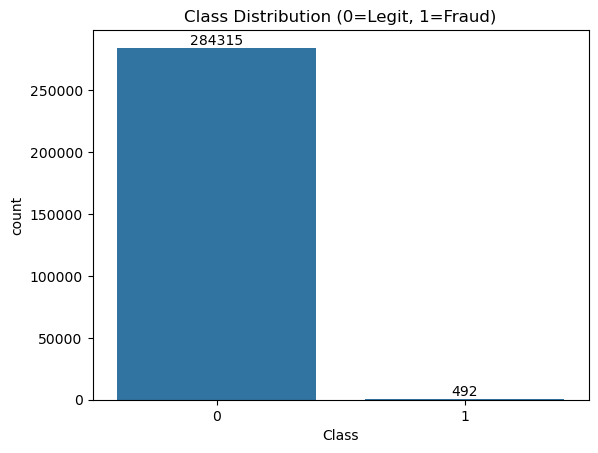

In [3]:
print('Legitimate transactions:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '%')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '%')


ax = sns.countplot(x='Class', data=df)
ax.set_title("Class Distribution (0=Legit, 1=Fraud)")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')
plt.show()

Clearly, the dataset is **highly imbalanced** and if we directly train our models on this dataset, it will assume that most transactions are legitimate, resulting in **high accuracy** but **poor recall** for fraud cases. We must use resampling techniques. 

## Amount Distribution (Log scale)

We examine the `Amount` distribution to understand skewness and outliers.  
Highly skewed features can disproportionately affect some models and can benefit from scaling (especially distance/gradient-based methods).


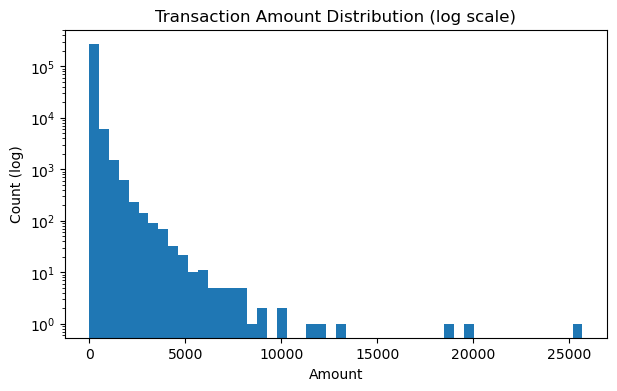

In [4]:
plt.figure(figsize=(7,4))
plt.hist(df['Amount'], bins=50)
plt.yscale('log')
plt.title("Transaction Amount Distribution (log scale)")
plt.xlabel("Amount")
plt.ylabel("Count (log)")
plt.show()

## Fraud vs Non-Fraud Amount

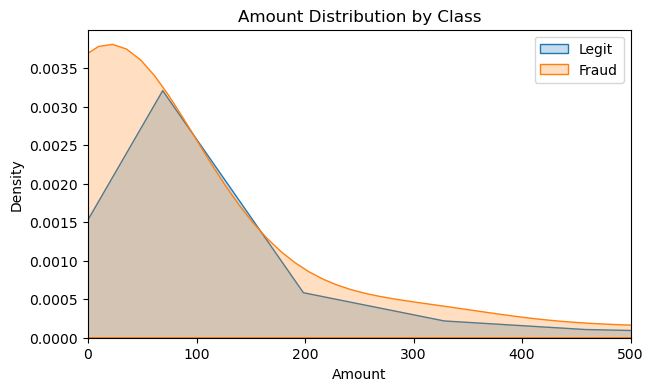

In [5]:
plt.figure(figsize=(7,4))
sns.kdeplot(df.loc[df['Class']==0, 'Amount'], label='Legit', fill=True)
sns.kdeplot(df.loc[df['Class']==1, 'Amount'], label='Fraud', fill=True)
plt.title("Amount Distribution by Class")
plt.xlim(0, 500) 
plt.legend()
plt.show()

## Transaction Time

`Time` represents seconds elapsed since the first recorded transaction. Its distribution reflects transaction activity patterns over time.  
Because `Time` spans a large numeric range, scaling helps stabilize optimization and prevents scale dominance in certain models.

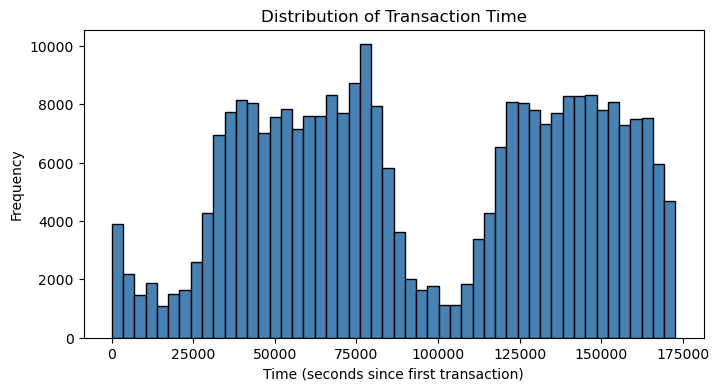

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(df['Time'], bins=50, color='steelblue', edgecolor='black')
plt.title("Distribution of Transaction Time")
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Frequency")
plt.show()

The distributions above (for Amount and Time)  reveal significant skewness and scale differences among features. To prevent these differences from disproportionately influencing model training, the Amount and Time features need to be scaled before proceeding.

## Stratified Train-Test Split

In [7]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train fraud rate:", y_train.mean())
print("Test fraud rate:", y_test.mean())


Train fraud rate: 0.001729245759178389
Test fraud rate: 0.0017204452090867595


## Scaling Amount and Time

Most features (V1–V28) are already PCA-transformed. `Time` and `Amount` are not.  
We scale these two to keep feature magnitudes comparable and to improve stability for models such as logistic regression and SVMs.

We use **RobustScaler** to reduce sensitivity to extreme values (median/IQR-based scaling).

In [8]:
scaler_amt = RobustScaler()
scaler_time = RobustScaler()

X_train = X_train.copy()
X_test = X_test.copy()

X_train['Amount'] = scaler_amt.fit_transform(X_train[['Amount']])
X_test['Amount']  = scaler_amt.transform(X_test[['Amount']])

X_train['Time'] = scaler_time.fit_transform(X_train[['Time']])
X_test['Time']  = scaler_time.transform(X_test[['Time']])

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Baseline Model: Logistic Regression with Class Weights (No resampling)

As a baseline, we train logistic regression with `class_weight='balanced'`.  
This does **not** change the dataset; it reweights the loss so misclassifying fraud is penalized more heavily.

This provides a strong reference point before applying resampling methods like SMOTE.

In [9]:
lr_weighted = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None)

lr_weighted.fit(X_train, y_train)
proba = lr_weighted.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print(classification_report(y_test, pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC:", average_precision_score(y_test, proba))

              precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0609    0.9184    0.1142        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5509     56962
weighted avg     0.9982    0.9755    0.9861     56962

ROC-AUC: 0.9720453671057617
PR-AUC: 0.7174539341990155


## Handling Class Imbalance 
To further address class imbalance, we experiment with two additional strategies:

1. SMOTE (Synthetic Minority Oversampling Technique), which generates synthetic samples of the minority class.
2. Tree-based models with built-in class weighting, such as Random Forests.

These approaches are evaluated and compared against the baseline model.


## SMOTE + Logistic Regression

In [10]:
smote_lr = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=2000))
])

smote_lr.fit(X_train, y_train)
proba = smote_lr.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC:", average_precision_score(y_test, proba))


ROC-AUC: 0.9712055545347008
PR-AUC: 0.7250575063969292


In [11]:
prec, rec, thr = precision_recall_curve(y_test, proba)

f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(f1)
best_thr = thr[best_idx]

print("Best threshold (by F1):", best_thr)
print("Precision:", prec[best_idx], "Recall:", rec[best_idx], "F1:", f1[best_idx])

pred_best = (proba >= best_thr).astype(int)
print(classification_report(y_test, pred_best, digits=4))


Best threshold (by F1): 0.9999999874704734
Precision: 0.8333333333333334 Recall: 0.8163265306122449 F1: 0.8247422680407371
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8333    0.8163    0.8247        98

    accuracy                         0.9994     56962
   macro avg     0.9165    0.9080    0.9122     56962
weighted avg     0.9994    0.9994    0.9994     56962



## Random Forest

Random Forests can capture nonlinear patterns and interactions.  
We use class weighting to improve minority-class learning without altering the test set.

In [12]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
rf.fit(X_train, y_train)
proba_rf = rf.predict_proba(X_test)[:, 1]

print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf))
print("RF PR-AUC:", average_precision_score(y_test, proba_rf))


RF ROC-AUC: 0.9514529116373619
RF PR-AUC: 0.8622354371738827


## Comparison

In [13]:
results = pd.DataFrame([
    {"Model": "LR (class_weight)", "PR-AUC": average_precision_score(y_test, lr_weighted.predict_proba(X_test)[:,1])},
    {"Model": "SMOTE + LR", "PR-AUC": average_precision_score(y_test, smote_lr.predict_proba(X_test)[:,1])},
    {"Model": "RF (balanced)", "PR-AUC": average_precision_score(y_test, proba_rf)},
]).sort_values("PR-AUC", ascending=False)

display(results)

,Model,PR-AUC
2,RF (balanced),0.862235
1,SMOTE + LR,0.725058
0,LR (class_weight),0.717454


This project demonstrates the importance of proper handling of class imbalance in fraud detection tasks. 
While simple linear models provide a strong baseline, ensemble methods such as Random Forests significantly 
improve performance by capturing nonlinear patterns in the data.

Future work could include hyperparameter tuning, gradient boosting models, or cost-sensitive learning.